# Model building and model selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_csv('HR_data.csv')

In [5]:
cols = df1.columns.tolist()
cols = cols[7:] + cols[:7]
df1 = df1[cols]
df1.head()

,promotion_last_5years,Department,salary,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left
0,0,sales,low,0.38,0.53,2,157,3,0,1
1,0,sales,medium,0.80,0.86,5,262,6,0,1
2,0,sales,medium,0.11,0.88,7,272,4,0,1
3,0,sales,low,0.72,0.87,5,223,5,0,1
4,0,sales,low,0.37,0.52,2,159,3,0,1


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   promotion_last_5years  14999 non-null  int64  
 1   Department             14999 non-null  object 
 2   salary                 14999 non-null  object 
 3   satisfaction_level     14999 non-null  float64
 4   last_evaluation        14999 non-null  float64
 5   number_project         14999 non-null  int64  
 6   average_montly_hours   14999 non-null  int64  
 7   time_spend_company     14999 non-null  int64  
 8   Work_accident          14999 non-null  int64  
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


## Feature Engineering

In [26]:
df2 = df1.copy()

In [27]:
df2.isnull().sum()

promotion_last_5years    0
Department               0
salary                   0
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
dtype: int64

In [28]:
df2['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [29]:
salary_dummies = pd.get_dummies(df2['salary'])
department_dummies = pd.get_dummies(df2['Department'])

In [30]:
df2 = pd.concat([df2, salary_dummies, department_dummies], axis=1)

In [31]:
df2.head()

,promotion_last_5years,Department,salary,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,...,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0,sales,low,0.38,0.53,2,157,3,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,sales,medium,0.80,0.86,5,262,6,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,sales,medium,0.11,0.88,7,272,4,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,sales,low,0.72,0.87,5,223,5,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,sales,low,0.37,0.52,2,159,3,0,1,...,0,0,0,0,0,0,0,1,0,0


In [32]:
# drop salary feature as we already applied label encoding tech
df2.drop(['salary', 'Department'], axis=1, inplace=True)

In [33]:
df2.head()

,promotion_last_5years,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,high,low,...,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0,0.38,0.53,2,157,3,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0.80,0.86,5,262,6,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0.11,0.88,7,272,4,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0.72,0.87,5,223,5,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0.37,0.52,2,159,3,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0


## Split Dataset into Training and Test set

In [36]:
X = df2.drop(labels='left', axis=1)
y = df2['left']

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model selection

In [54]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [66]:
# create parameter

model_param = {
    'RandomForestClassifier':{
        'model': RandomForestClassifier(),
        'param':{
            'n_estimators': [10, 50, 100, 130],
            'criterion': ['gini', 'entropy'],
            'max_depth': range(2, 4, 1),
            'max_features': ['sqrt', 'log2']
        }
    },
    'XGBClassifier':{
        'model': XGBClassifier(objective='binary:logistic'),
        'param':{
            'learning_rate': [0.5, 0.1, 0.01, 0.001],
            'max_depth': [3, 5, 10, 20],
            'n_estimators': [10, 50, 100, 200]
        }
    }
}

In [67]:
scores = []
for m_name, m_param in model_param.items():
    model_selection = GridSearchCV(estimator=m_param['model'], param_grid=m_param['param'], cv=5, return_train_score=False)
    model_selection.fit(X, y)
    scores.append({
        'model': m_name,
        'best_score': model_selection.best_score_,
        'best_params': model_selection.best_params_
    })

In [68]:
scores

[{'model': 'RandomForestClassifier',
  'best_score': 0.9169279537623651,
  'best_params': {'criterion': 'gini',
   'max_depth': 3,
   'max_features': 'sqrt',
   'n_estimators': 100}},
 {'model': 'XGBClassifier',
  'best_score': 0.9905995109480937,
  'best_params': {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}}]

## Model building

In [69]:
model_xgb = XGBClassifier(objective='binary:logistic', learning_rate=0.1, max_depth=20, n_estimators=200)

In [70]:
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [71]:
model_xgb.score(X_test, y_test)

0.988

In [72]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, model_xgb.predict(X_test))
cm

array([[2282,   12],
       [  24,  682]], dtype=int64)

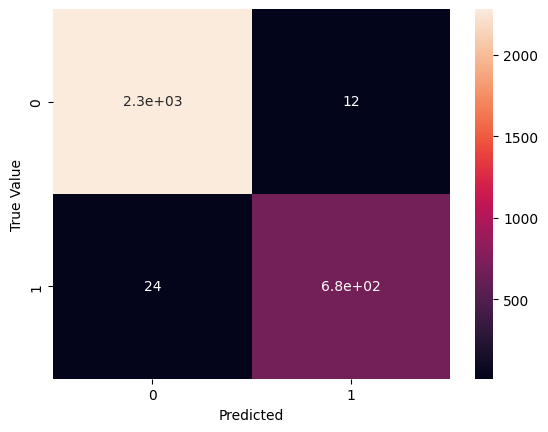

In [73]:
# plot the graph
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True Value')
plt.show()